# Buy Till You Die Analysis With PyMC Marketing

# Introduction

This article is a walk thru of how to use Python to model customer purchasing behavior via Buy Till You Die BTYD Models
using a publicly available set of transactional purchase records and customer details from the Online Retail II data set 
which contains all the transactions occurring for a UK-based and registered, non-store online retail between 
01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware 
where many customers of the company are wholesalers.
<https://archive.ics.uci.edu/dataset/502/online+retail+ii>. 

This site has an accompanying article on Medium here https://zhijingeu.medium.com/estimating-customer-lifetime-value-with-buy-till-you-die-modelling-python-pymc-marketing-85bc64fce8a6

# <b>Data Exploration & Preparation<b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#df1 = pd.read_excel("/kaggle/input/online-retail-dataset/online_retail_II.xlsx", sheet_name="Year 2009-2010")
#df2 = pd.read_excel("/kaggle/input/online-retail-dataset/online_retail_II.xlsx", sheet_name="Year 2010-2011")

df1= pd.read_csv('online_retail_II_2009-10.csv')
df2= pd.read_csv('online_retail_II_2010-11.csv')

data_by_line_item_transaction_raw=pd.concat([df1, df2], sort=False)
data_by_line_item_transaction_raw["TotalPrice"] = data_by_line_item_transaction_raw["Quantity"] * data_by_line_item_transaction_raw["Price"]

In [3]:
data_by_line_item_transaction_raw

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France,14.85


In [4]:
#According to the documentation if the Invoice code starts with the letter 'c', it indicates a cancellation.
#Therefore filtering to view them before we remove these

CancelledTransactions = data_by_line_item_transaction_raw[data_by_line_item_transaction_raw["Invoice"].str.contains("C", na=False)]
CancelledTransactions

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,1/12/2009 10:33,2.95,16321.0,Australia,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,1/12/2009 10:33,1.65,16321.0,Australia,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,1/12/2009 10:33,4.25,16321.0,Australia,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,1/12/2009 10:33,2.10,16321.0,Australia,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,1/12/2009 10:33,2.95,16321.0,Australia,-35.40
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,9/12/2011 9:57,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,9/12/2011 10:28,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,9/12/2011 11:57,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,9/12/2011 11:58,1.25,17315.0,United Kingdom,-1.25


In [5]:
#removing cancelled invoices and NaN invoices
data_by_line_item_transaction = data_by_line_item_transaction_raw[~data_by_line_item_transaction_raw["Invoice"].str.contains("C", na=False)]
data_by_line_item_transaction

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France,14.85


In [6]:
#removing other NaN rows for Invoice Id , Quantity, Date etc
data_by_line_item_transaction_clean=data_by_line_item_transaction.dropna(subset = ['Invoice', 'Quantity', 'InvoiceDate','Price','Customer ID'])
data_by_line_item_transaction_clean

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1/12/2009 7:45,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,1/12/2009 7:45,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1/12/2009 7:45,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1/12/2009 7:45,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France,14.85


In [7]:
from datetime import datetime
# date_format = '%Y/%m/%d %H:%M:%S'
date_format = '%d/%m/%Y %H:%M'

full_data_by_line_item_transaction_clean=data_by_line_item_transaction_clean.copy()

full_data_by_line_item_transaction_clean['InvoiceDate']=pd.to_datetime(data_by_line_item_transaction_clean['InvoiceDate'], format= date_format)

full_data_by_line_item_transaction_clean["Transaction Id"]=full_data_by_line_item_transaction_clean.index

full_data_by_line_item_transaction_clean

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Transaction Id
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,3
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,4
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,541905
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,541906
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,541907
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,541908


In [8]:
data_by_line_item_transaction_clean.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Invoice,805620,36975,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,805620,4631,85123A,5188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,805620,5283,WHITE HANGING HEART T-LIGHT HOLDER,5181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,805620.0,NaN,NaN,NaN,13.307665,144.306739,1.0,2.0,5.0,12.0,80995.0
InvoiceDate,805620,34591,14/11/2011 15:27,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,805620.0,NaN,NaN,NaN,3.206279,29.197901,0.0,1.25,1.95,3.75,10953.5
Customer ID,805620.0,NaN,NaN,NaN,15331.85625,1696.768395,12346.0,13982.0,15271.0,16805.0,18287.0
Country,805620,41,United Kingdom,725296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalPrice,805620.0,NaN,NaN,NaN,22.024564,224.03215,0.0,4.95,11.85,19.5,168469.6


# Basic Exploratory Data Analysis

,Invoice Count Per Day
InvoiceDateOnly,
2009-12-01,98
2009-12-02,110
2009-12-03,122
2009-12-04,80
2009-12-05,30
...,...
2011-12-05,116
2011-12-06,110
2011-12-07,104


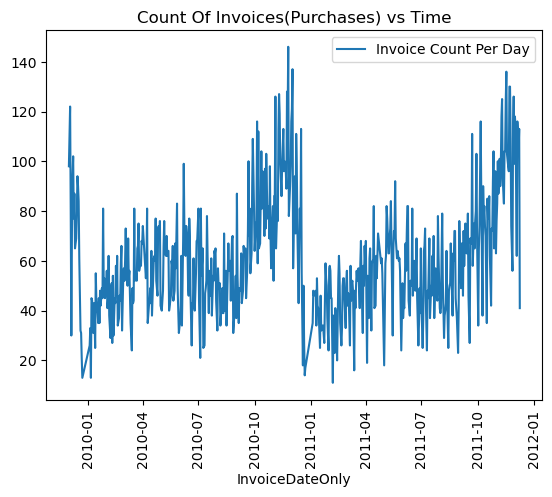

In [9]:
full_data_by_line_item_transaction_clean_copy=full_data_by_line_item_transaction_clean.copy()
full_data_by_line_item_transaction_clean_copy['InvoiceDateOnly']=pd.DatetimeIndex(full_data_by_line_item_transaction_clean_copy['InvoiceDate']).date

df_TotalInvoicesByDate=full_data_by_line_item_transaction_clean_copy[["Invoice","InvoiceDateOnly"]].groupby("InvoiceDateOnly").agg('nunique')
df_TotalInvoicesByDate = df_TotalInvoicesByDate.rename(columns={'Invoice': 'Invoice Count Per Day'})

df_TotalInvoicesByDate.plot(y="Invoice Count Per Day", kind='line', rot='vertical',title='Count Of Invoices(Purchases) vs Time')
df_TotalInvoicesByDate

<Axes: title={'center': 'Purchase Values vs Time'}, xlabel='InvoiceDateOnly'>

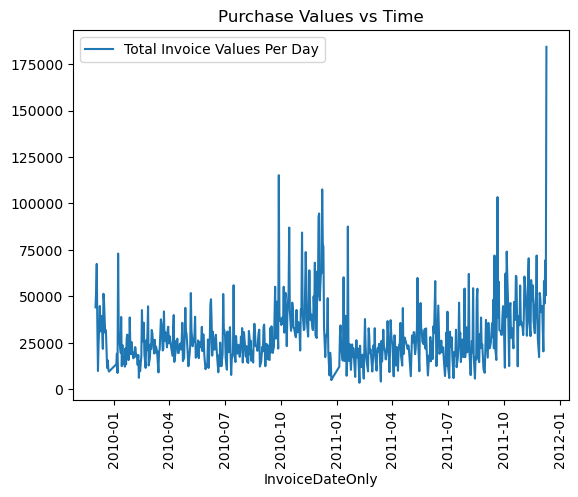

In [10]:
df_TotalPurchaseValueByDate=full_data_by_line_item_transaction_clean_copy[["InvoiceDateOnly","TotalPrice"]].groupby("InvoiceDateOnly").agg('sum')

df_TotalPurchaseValueByDate = df_TotalPurchaseValueByDate.rename(columns={'TotalPrice': 'Total Invoice Values Per Day'})

df_TotalPurchaseValueByDate.plot(kind='line', rot='vertical',title='Purchase Values vs Time')


<Axes: ylabel='Country'>

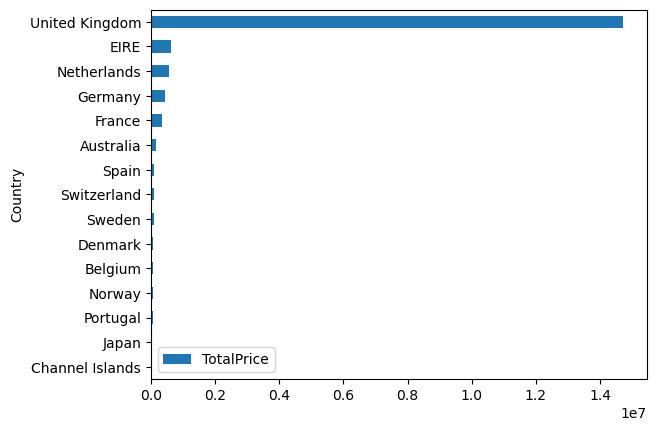

In [11]:
#Top Countries By Spend
df_country_spend = pd.DataFrame(full_data_by_line_item_transaction_clean.groupby("Country")['TotalPrice'].sum())
df_country_spend.sort_values("TotalPrice",ascending=True).tail(15).plot(kind='barh')


<Axes: ylabel='Description'>

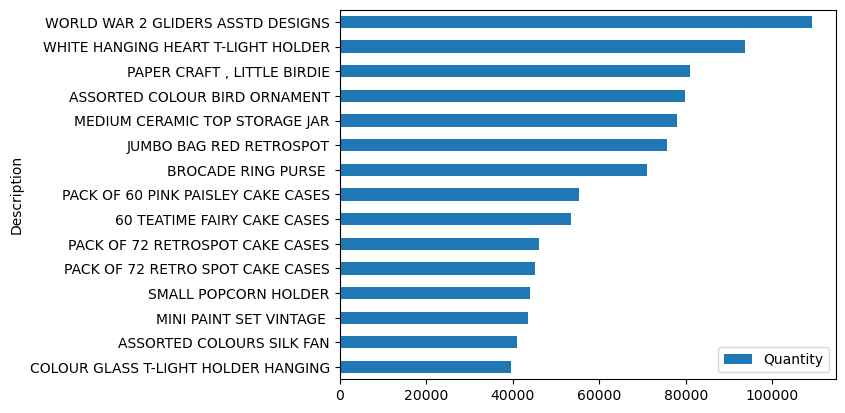

In [12]:
#Top Products By Quantity Purchased
df_product_quantity = pd.DataFrame(full_data_by_line_item_transaction_clean.groupby("Description")["Quantity"].sum())
df_product_quantity.sort_values("Quantity",ascending=True).tail(15).plot(kind='barh')


array([[<Axes: title={'center': 'TotalPrice'}>]], dtype=object)

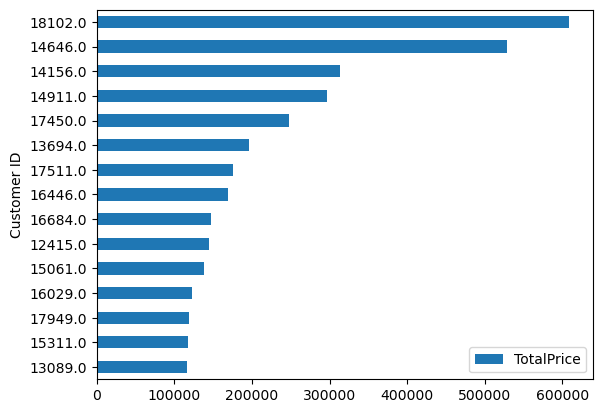

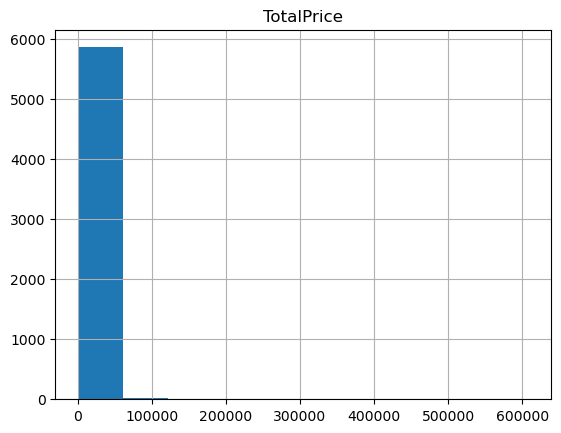

In [13]:
#Top Customers By Spend
df_customer_spend = pd.DataFrame(full_data_by_line_item_transaction_clean.groupby("Customer ID")['TotalPrice'].sum())
df_customer_spend.sort_values("TotalPrice",ascending=True).tail(15).plot(kind='barh')
df_customer_spend.hist()
#very skewed behaviors

<b>Optional Function To Roll Up Dataset From Invoice Line-Item Level To Invoice Level</b>
<br>Note - not required as the results of the BTYD will be similar

In [14]:
# InvoiceToCustomer = pd.DataFrame(data_by_line_item_transaction_clean.groupby('Invoice')['Customer ID'].first())
# InvoiceToTotalPrice = data_by_line_item_transaction_clean.groupby('Invoice').agg({'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
# InvoiceToDate = pd.DataFrame(data_by_line_item_transaction_clean.groupby('Invoice')['InvoiceDate'].first())
# data_by_Invoice=InvoiceToCustomer.join(InvoiceToTotalPrice)
# data_by_Invoice=data_by_Invoice.join(InvoiceToDate)

In [15]:
# data_by_Invoice.reset_index()
# data_by_Invoice['InvoiceDate']=pd.to_datetime(data_by_Invoice['InvoiceDate'], format= '%d/%m/%Y %H:%M')

In [16]:
min_date=min(full_data_by_line_item_transaction_clean['InvoiceDate'])
max_date = max(full_data_by_line_item_transaction_clean['InvoiceDate'])
full_max_date=max_date

In [17]:
display("Max Date: "+str(max_date))
display("Min Date: "+str(min_date))
display("Total Dur Days: " +str((max_date-min_date).days))
display("Total Dur Weeks: " +str(round((max_date-min_date).days/7,1)))
display("Total Dur Mths: " +str(round((max_date-min_date).days/30.417,1)))


'Max Date: 2011-12-09 12:50:00'

'Min Date: 2009-12-01 07:45:00'

'Total Dur Days: 738'

'Total Dur Weeks: 105.4'

'Total Dur Mths: 24.3'

# Train/Test Split 
<p>Split the full data set into calibration(train) and hold-out(test) datasets</p>

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
data=full_data_by_line_item_transaction_clean.sort_values('InvoiceDate')
# data["InvoiceId"]=data.index

In [20]:
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

In [21]:
train_min_date=min(train_data['InvoiceDate'])
train_max_date = max(train_data['InvoiceDate'])
display("Training Data Max Date: "+str(train_max_date))
display("Training Data Min Date: "+str(train_min_date))
display("Training Data Total Dur Days: " +str((train_max_date-train_min_date).days))
display("Training Data Total Dur Weeks: " +str(round((train_max_date-train_min_date).days/7,1)))
display("Training Data Total Dur Mths: " +str(round((train_max_date-train_min_date).days/30.417,1)))

'Training Data Max Date: 2011-06-12 13:51:00'

'Training Data Min Date: 2009-12-01 07:45:00'

'Training Data Total Dur Days: 558'

'Training Data Total Dur Weeks: 79.7'

'Training Data Total Dur Mths: 18.3'

In [22]:
train_data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Transaction Id
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,3
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,4
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6,5
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,6
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5,7
11,489435,22353,LUNCHBOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6,11
10,489435,22195,HEART MEASURING SPOONS LARGE,24,2009-12-01 07:46:00,1.65,13085.0,United Kingdom,39.6,10


In [23]:
train_data.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice,Transaction Id
count,563934.000000,563934,563934.000000,563934.000000,563934.000000,563934.000000
mean,13.504187,2010-09-09 01:23:55.880474880,3.297741,15344.786503,22.059698,224374.379924
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.000000,0.000000
25%,2.000000,2010-05-07 14:52:00,1.250000,13975.000000,4.950000,104195.000000
50%,5.000000,2010-09-30 11:51:00,1.950000,15298.000000,12.500000,195896.500000
75%,12.000000,2010-12-10 12:20:00,3.750000,16814.000000,19.500000,345458.750000
max,74215.000000,2011-06-12 13:51:00,10953.500000,18287.000000,77183.600000,525460.000000
std,130.969209,NaN,32.363199,1692.833452,138.461183,146364.053158


In [24]:
calibration_period_end = train_max_date
observation_period_end = full_max_date
NoOfDaysToPredict = observation_period_end-calibration_period_end

print(NoOfDaysToPredict.days) 


179


# Develop function to calculate RFM Characteristics
<br>This function calculates the RFM figures both in a naive way to demonstrate the differences with the lifetimes/Py MC automated summarizer functions such as:
<br>
<ul>
<li>Frequency is minus one as first purchase is by default NOT counted</li>
<li>Frequency estimate depends on time granularity (e.g. Multiple same day purchases only counts as single purchase at a date level</li>
<li>Recency - Unlike some sources define this alternatively as time since last order or purchase BUT for BTYD modelling is time between first purchase and their latest purchase</li>
<li>Monetary value is actually calculated EXCLUDING the first purchase by the customer</li>
</ul>

Reference https://lifetimes.readthedocs.io/en/latest/Quickstart.html#the-shape-of-your-data
    
Frequency represents the number of repeat purchases the customer has made. 
This means that it’s ONE LESS the total number of purchases. 
This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. 
So if using days as units, then it’s the count of days the customer had a purchase on.

T (Age) represents the age of the customer in whatever time units chosen 
This is equal to the duration between a customer’s first purchase and the end of the period under study.

Recency represents the age of the customer when they made their most recent purchases. 
This is equal to the duration between a customer’s first purchase and their latest purchase. 
(Thus if they have made only 1 purchase, the recency is 0.)

Monetary_value represents the average value of a given customer’s purchases. 
This is equal to the sum of all a customer’s purchases divided by the total number of purchases. 
Note that the denominator here is different than the frequency described above.

In [25]:
def create_RFM_Table(data,order_id,customer_id,timestamp,monetary_value,granularity):
    
    max_date=data[timestamp].max()
    latest_order_date = pd.DataFrame(data.groupby([customer_id])[timestamp].max())
    latest_order_date.rename(columns = {timestamp:'Most Recent Order Date'}, inplace = True)
    latest_order_date["customer_unique_id"]=latest_order_date.index

    earliest_order_date=pd.DataFrame(data.groupby([customer_id])[timestamp].min())
    earliest_order_date.rename(columns = {timestamp:'Earliest Order Date'}, inplace = True)
    earliest_order_date["Age"]=(max_date-earliest_order_date["Earliest Order Date"]).dt.round("d")
    earliest_order_date['Age In Days'] = earliest_order_date['Age'] / pd.to_timedelta(1, unit='D')
    earliest_order_date.drop(['Age'], axis=1, inplace=True)    
    earliest_order_date["customer_unique_id"]=earliest_order_date.index

    recency_df=pd.merge(latest_order_date[["Most Recent Order Date"]],
                            earliest_order_date[["Earliest Order Date","Age In Days"]],
                            left_index=True, right_index=True)

    recency_df["recency"]=recency_df["Most Recent Order Date"]-recency_df["Earliest Order Date"]

    recency_df["recency"]=recency_df["recency"].dt.round("d")
    recency_df.rename(columns = {"recency":"Recency In Days"}, inplace = True)
    recency_df['Recency In Days'] = recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')
    recency_df[customer_id]=recency_df.index
    recency_df.reset_index(inplace = True, drop = True)

    if granularity=="True":
#This snip provides a higher granularity -count by specific time stamp not just day
        frequency_df = data.groupby([customer_id]).agg({order_id: "nunique"}).reset_index()
        frequency_df.sort_values(order_id, ascending=[False])
        frequency_df.rename(columns = {order_id:'Frequency'}, inplace = True)
    
    else :
#This snip provides a granularity count by specific DATE - i.e multiple purchases on same day only count as ONE purchase
        data['InvoiceDateOnly'] = data[timestamp].dt.date
        first_date=data.groupby([customer_id,'InvoiceDateOnly']).first().reset_index()
        frequency_df= first_date.groupby([customer_id]).agg({order_id: "nunique"}).reset_index()
        frequency_df.sort_values(order_id, ascending=[False])
        frequency_df.rename(columns = {order_id:'Frequency'}, inplace = True)

    if granularity=="True":
        
        monetary_df = data.groupby(customer_id, as_index = False)[monetary_value].sum()
        monetary_df.rename(columns = {monetary_value:'Total Monetary Value'}, inplace = True)

    else :
        CustomerRecords=data
        CustomerRecords['InvoiceDateOnly'] = data[timestamp].dt.date
        countOfPurchByDate=CustomerRecords.groupby([customer_id,'InvoiceDateOnly']).count().reset_index()
        countOfPurchByDate=countOfPurchByDate.rename(columns = {order_id:'Count Of Purchases On Same Day'})

        TotalTrxRowsWithMultipleSameDayPurch=str(len(countOfPurchByDate[countOfPurchByDate['Count Of Purchases On Same Day'] > 1]))
        TotalTrxRows=str(len(countOfPurchByDate[countOfPurchByDate['Count Of Purchases On Same Day'] > 0]))

        ##
        sumOfPurchByDate = CustomerRecords.groupby([customer_id,'InvoiceDateOnly'], as_index = False)[monetary_value].sum().reset_index()
        sumOfPurchByDate.rename(columns = {'TotalPrice':'Total Purchase Value On Same Day'}, inplace = True)

        countOfPurchByDate["Total Purchase Value On Same Day"]=sumOfPurchByDate["Total Purchase Value On Same Day"]
        countOfPurchByDate=countOfPurchByDate[[customer_id,"InvoiceDateOnly","Count Of Purchases On Same Day","Total Purchase Value On Same Day"]]
        countOfPurchByDate.sort_values(by=[customer_id, 'InvoiceDateOnly'])

        valueOfFirstPurchase=countOfPurchByDate.groupby(customer_id).first()
        valueOfFirstPurchase.reset_index(inplace=True)

        monetary_df = CustomerRecords.groupby(customer_id, as_index = False)[monetary_value].sum()
        monetary_df.rename(columns = {monetary_value:'Total Monetary Value'}, inplace = True)
        monetary_df=monetary_df.merge(valueOfFirstPurchase[[customer_id,"Total Purchase Value On Same Day"]],on="Customer ID", how='left')
        monetary_df = monetary_df.rename(columns={"Total Purchase Value On Same Day": 'First Time Purchase Value'})
    ##    
    
    RFM = pd.merge(frequency_df,recency_df, on=customer_id)
    RFM = pd.merge(RFM, monetary_df, on=customer_id)
    RFM["Frequency Minus 1"]=RFM["Frequency"]-1
    
    if granularity=="True":
        RFM["Average Time Between Orders In Days"]=""
        RFM["Average Monetary Value Per Order"]=""
        RFM=RFM[[customer_id,'Frequency','Frequency Minus 1','Recency In Days','Age In Days',
                  'Earliest Order Date','Most Recent Order Date',"Total Monetary Value",
                 "Average Time Between Orders In Days","Average Monetary Value Per Order"]]
    else:
        RFM["Average Time Between Orders In Days"]=RFM['Age In Days']/RFM['Frequency Minus 1']
        RFM["Average Monetary Value Per Order"]=(RFM['Total Monetary Value']-RFM['First Time Purchase Value'])/RFM['Frequency Minus 1']
        RFM=RFM[[customer_id,'Frequency','Frequency Minus 1','Recency In Days','Age In Days',
                  'Earliest Order Date','Most Recent Order Date',"Total Monetary Value",
                 "First Time Purchase Value","Average Time Between Orders In Days","Average Monetary Value Per Order"]]

    RFM.sort_values('Frequency',ascending=[False])

    RFM=RFM.sort_values('Frequency',ascending=[False])

    RFM["Average Time Between Orders In Days"]=RFM["Average Time Between Orders In Days"].replace([np.inf, -np.inf], 0)
    RFM["Average Monetary Value Per Order"]=RFM["Average Monetary Value Per Order"].fillna(0)

    return RFM

In [26]:
create_RFM_Table(train_data,'Transaction Id','Customer ID','InvoiceDate','TotalPrice',"True")

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order Date,Most Recent Order Date,Total Monetary Value,Average Time Between Orders In Days,Average Monetary Value Per Order
4605,17841.0,7357,7356,554.0,557.0,2009-12-02 15:41:00,2011-06-09 16:10:00,42758.96,,
2126,14911.0,7213,7212,555.0,558.0,2009-12-01 11:41:00,2011-06-09 13:46:00,195537.25,,
1861,14606.0,5281,5280,553.0,556.0,2009-12-03 12:40:00,2011-06-09 13:08:00,25810.44,,
309,12748.0,4054,4053,553.0,555.0,2009-12-04 17:31:00,2011-06-10 16:47:00,32897.91,,
2472,15311.0,3307,3306,553.0,558.0,2009-12-01 11:21:00,2011-06-07 13:56:00,89729.37,,
...,...,...,...,...,...,...,...,...,...,...
1423,14095.0,1,0,0.0,542.0,2009-12-17 12:49:00,2009-12-17 12:49:00,2.95,,
1419,14090.0,1,0,0.0,144.0,2011-01-19 10:51:00,2011-01-19 10:51:00,76.32,,
1624,14328.0,1,0,0.0,258.0,2010-09-27 16:01:00,2010-09-27 16:01:00,445.05,,
1409,14079.0,1,0,0.0,502.0,2010-01-26 17:19:00,2010-01-26 17:19:00,243.63,,


In [27]:
IndividualCustomerRecords=train_data[train_data['Customer ID'] == 14911.0]
IndividualCustomerRecords.head(45)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Transaction Id
457,489520,22282,12 EGG HOUSE PAINTED WOOD,4,2009-12-01 11:41:00,12.75,14911.0,EIRE,51.00,457
459,489520,22089,PAPER BUNTING VINTAGE PAISLEY,6,2009-12-01 11:41:00,2.95,14911.0,EIRE,17.70,459
460,489520,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,4,2009-12-01 11:41:00,3.75,14911.0,EIRE,15.00,460
461,489520,20734,SILVER MINI TAPE MEASURE,10,2009-12-01 11:41:00,0.85,14911.0,EIRE,8.50,461
462,489520,21133,PAINTED BIRD ASSORTED CHRISTMAS,12,2009-12-01 11:41:00,1.69,14911.0,EIRE,20.28,462
463,489520,35071,ASSORTED SANTA CHRISTMAS DECORATION,12,2009-12-01 11:41:00,0.85,14911.0,EIRE,10.20,463
467,489520,21485,RED SPOT HEART HOT WATER BOTTLE,3,2009-12-01 11:41:00,4.95,14911.0,EIRE,14.85,467
465,489520,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2009-12-01 11:41:00,2.95,14911.0,EIRE,17.70,465
466,489520,22121,NOEL WOODEN BLOCK LETTERS,3,2009-12-01 11:41:00,5.95,14911.0,EIRE,17.85,466
468,489520,84836,ZINC METAL HEART DECORATION,12,2009-12-01 11:41:00,1.25,14911.0,EIRE,15.00,468


<p>There are multiple purchases on the same day which makes analysis via the BTYD tricky</p>
<p>Therefore we will treat multiple purchases on the same day as a single purchase for the Frequency count</p>

In [28]:
def AggregatePurchasesByCustomerByDate(data,order_id,customer_id,timestamp,monetary_value):
    CustomerRecords=data
    CustomerRecords['InvoiceDateOnly'] = train_data[timestamp].dt.date
    countOfPurchByDate=CustomerRecords.groupby([customer_id,'InvoiceDateOnly']).count().reset_index()
    countOfPurchByDate=countOfPurchByDate.rename(columns = {order_id:'Count Of Purchases On Same Day'})
        
    sumOfPurchByDate = CustomerRecords.groupby([customer_id,'InvoiceDateOnly'], as_index = False)[monetary_value].sum().reset_index()
    sumOfPurchByDate.rename(columns = {'TotalPrice':'Total Purchase Value On Same Day'}, inplace = True)

    TotalTrxRowsWithMultipleSameDayPurch=str(len(countOfPurchByDate[countOfPurchByDate['Count Of Purchases On Same Day'] > 1]))
    TotalTrxRows=str(len(countOfPurchByDate[countOfPurchByDate['Count Of Purchases On Same Day'] > 0]))
    
#     print("There are "+TotalTrxRowsWithMultipleSameDayPurch+" of records with multiple purchase on"+
#     " the same day out of the total "+TotalTrxRows+" of records")
    
    RecordsWithMultiplePurchasesPerDay=countOfPurchByDate[countOfPurchByDate['Count Of Purchases On Same Day'] > 1]

    RecordsWithMultiplePurchasesPerDay=RecordsWithMultiplePurchasesPerDay.merge(sumOfPurchByDate[[customer_id,"InvoiceDateOnly","Total Purchase Value On Same Day"]],on=["Customer ID","InvoiceDateOnly"], how='left')
    
    RecordsWithMultiplePurchasesPerDay = RecordsWithMultiplePurchasesPerDay[[customer_id,"InvoiceDateOnly",
                                                                            "Count Of Purchases On Same Day",
                                                                            "Total Purchase Value On Same Day"]]
    
    return RecordsWithMultiplePurchasesPerDay

In [29]:
AggPurchasesByCustomerByDate=AggregatePurchasesByCustomerByDate(train_data,'Transaction Id','Customer ID','InvoiceDate','TotalPrice')
AggPurchasesByCustomerByDate


,Customer ID,InvoiceDateOnly,Count Of Purchases On Same Day,Total Purchase Value On Same Day
0,12346.0,2009-12-14,3,90.00
1,12346.0,2009-12-18,2,23.50
2,12346.0,2010-01-04,2,45.00
3,12346.0,2010-03-02,5,27.05
4,12346.0,2010-06-28,19,142.31
...,...,...,...,...
22407,18286.0,2010-08-20,50,833.48
22408,18287.0,2010-05-17,54,1071.61
22409,18287.0,2010-09-21,21,892.60
22410,18287.0,2010-11-22,10,381.50


In [30]:
AggPurchasesByCustomerByDate[AggPurchasesByCustomerByDate['Customer ID'] == 14911.0]

,Customer ID,InvoiceDateOnly,Count Of Purchases On Same Day,Total Purchase Value On Same Day
9818,14911.0,2009-12-01,30,733.63
9819,14911.0,2009-12-07,60,1641.30
9820,14911.0,2009-12-08,23,728.05
9821,14911.0,2009-12-10,19,377.57
9822,14911.0,2009-12-15,58,1413.34
...,...,...,...,...
9983,14911.0,2011-05-23,52,1007.75
9984,14911.0,2011-05-26,28,494.04
9985,14911.0,2011-06-07,13,254.31
9986,14911.0,2011-06-08,65,3351.32


In [31]:
RFM_Train=create_RFM_Table(train_data,'Transaction Id','Customer ID','InvoiceDate','TotalPrice',"Day")

RFM_Train

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order Date,Most Recent Order Date,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Order
2126,14911.0,173,172,555.0,558.0,2009-12-01 11:41:00,2011-06-09 13:46:00,195537.25,733.63,3.244186,1132.579186
2472,15311.0,150,149,553.0,558.0,2009-12-01 11:21:00,2011-06-07 13:56:00,89729.37,823.02,3.744966,596.686913
1861,14606.0,140,139,553.0,556.0,2009-12-03 12:40:00,2011-06-09 13:08:00,25810.44,215.00,4.000000,184.139856
309,12748.0,134,133,553.0,555.0,2009-12-04 17:31:00,2011-06-10 16:47:00,32897.91,220.90,4.172932,245.691805
4605,17841.0,128,127,554.0,557.0,2009-12-02 15:41:00,2011-06-09 16:10:00,42758.96,530.76,4.385827,332.505512
...,...,...,...,...,...,...,...,...,...,...,...
3461,16492.0,1,0,0.0,360.0,2010-06-17 08:20:00,2010-06-17 08:20:00,385.56,385.56,0.000000,0.000000
3460,16491.0,1,0,0.0,233.0,2010-10-22 15:42:00,2010-10-22 15:42:00,801.66,801.66,0.000000,0.000000
3459,16490.0,1,0,0.0,256.0,2010-09-29 16:30:00,2010-09-29 16:30:00,205.41,205.41,0.000000,0.000000
3456,16486.0,1,0,0.0,357.0,2010-06-20 12:16:00,2010-06-20 12:16:00,134.36,134.36,0.000000,0.000000


# Create Combined View Of HoldOut and Calib Data
<p> Combines view of RFM for Train Data Period and Frequency (Purch Count) & Total Purchase Value In Test Data Period</p>

In [32]:
RFM_Full=create_RFM_Table(data,'Transaction Id','Customer ID','InvoiceDate','TotalPrice',"Day")
RFM_Full

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order Date,Most Recent Order Date,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Order
2541,14911.0,255,254,737.0,738.0,2009-12-01 11:41:00,2011-12-08 15:54:00,295972.63,733.63,2.905512,1162.358268
400,12748.0,203,202,735.0,735.0,2009-12-04 17:31:00,2011-12-09 12:20:00,56599.39,220.90,3.638614,279.101436
2938,15311.0,196,195,738.0,738.0,2009-12-01 11:21:00,2011-12-09 12:00:00,116771.16,823.02,3.784615,594.605846
5436,17841.0,193,192,736.0,737.0,2009-12-02 15:41:00,2011-12-08 12:07:00,70884.07,530.76,3.838542,366.423490
2239,14606.0,181,180,735.0,736.0,2009-12-03 12:40:00,2011-12-08 19:28:00,30861.06,215.00,4.088889,170.255889
...,...,...,...,...,...,...,...,...,...,...,...
2869,15242.0,1,0,0.0,422.0,2010-10-13 15:33:00,2010-10-13 15:33:00,302.04,302.04,0.000000,0.000000
513,12861.0,1,0,0.0,619.0,2010-03-30 11:39:00,2010-03-30 11:39:00,68.25,68.25,0.000000,0.000000
1087,13445.0,1,0,0.0,626.0,2010-03-23 15:34:00,2010-03-23 15:34:00,241.90,241.90,0.000000,0.000000
4497,16886.0,1,0,0.0,456.0,2010-09-09 15:08:00,2010-09-09 15:08:00,134.00,134.00,0.000000,0.000000


In [33]:
TempTable=RFM_Full[['Customer ID','Frequency','Total Monetary Value']].rename(columns = 
                                                                     {'Frequency':'Frequency_Full',
                                                                     'Total Monetary Value':'Total Monetary Value_Full'})

RFM_CalibrationVsHoldOut=RFM_Train.merge(TempTable,on="Customer ID",how="left")

RFM_CalibrationVsHoldOut['Frequency_HoldOut_Period']=RFM_CalibrationVsHoldOut['Frequency_Full']-RFM_CalibrationVsHoldOut['Frequency']

RFM_CalibrationVsHoldOut['Total Monetary Value_HoldOut_Period']=RFM_CalibrationVsHoldOut['Total Monetary Value_Full']-RFM_CalibrationVsHoldOut['Total Monetary Value']


RFM_CalibrationVsHoldOut.drop(['Frequency_Full','Total Monetary Value_Full'], axis=1,inplace=True)

In [34]:
RFM_CalibrationVsHoldOut

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order Date,Most Recent Order Date,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Order,Frequency_HoldOut_Period,Total Monetary Value_HoldOut_Period
0,14911.0,173,172,555.0,558.0,2009-12-01 11:41:00,2011-06-09 13:46:00,195537.25,733.63,3.244186,1132.579186,82,100435.38
1,15311.0,150,149,553.0,558.0,2009-12-01 11:21:00,2011-06-07 13:56:00,89729.37,823.02,3.744966,596.686913,46,27041.79
2,14606.0,140,139,553.0,556.0,2009-12-03 12:40:00,2011-06-09 13:08:00,25810.44,215.00,4.000000,184.139856,41,5050.62
3,12748.0,134,133,553.0,555.0,2009-12-04 17:31:00,2011-06-10 16:47:00,32897.91,220.90,4.172932,245.691805,69,23701.48
4,17841.0,128,127,554.0,557.0,2009-12-02 15:41:00,2011-06-09 16:10:00,42758.96,530.76,4.385827,332.505512,65,28125.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4974,16492.0,1,0,0.0,360.0,2010-06-17 08:20:00,2010-06-17 08:20:00,385.56,385.56,0.000000,0.000000,0,0.00
4975,16491.0,1,0,0.0,233.0,2010-10-22 15:42:00,2010-10-22 15:42:00,801.66,801.66,0.000000,0.000000,1,731.50
4976,16490.0,1,0,0.0,256.0,2010-09-29 16:30:00,2010-09-29 16:30:00,205.41,205.41,0.000000,0.000000,0,0.00
4977,16486.0,1,0,0.0,357.0,2010-06-20 12:16:00,2010-06-20 12:16:00,134.36,134.36,0.000000,0.000000,0,0.00


<Axes: title={'center': 'Recency'}, ylabel='Frequency'>

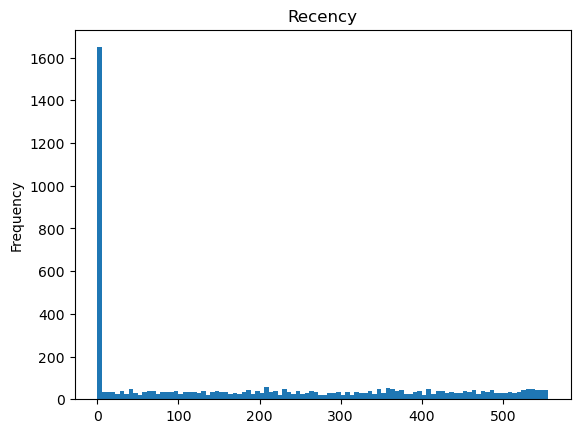

In [35]:
RFM_CalibrationVsHoldOut['Recency In Days'].plot(kind="hist", bins=100,title="Recency")

<Axes: title={'center': 'Frequency'}, ylabel='Frequency'>

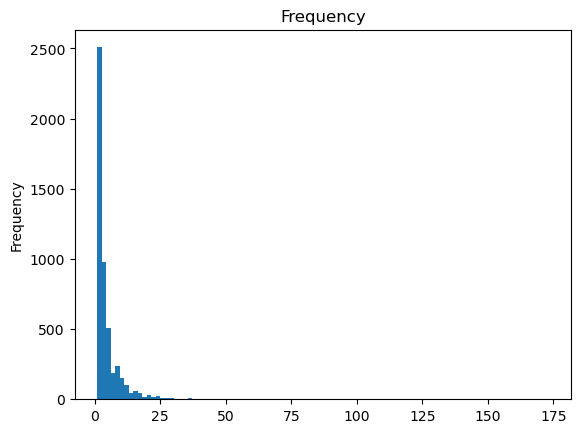

In [36]:
RFM_CalibrationVsHoldOut['Frequency'].plot(kind="hist", bins=100,title="Frequency")

<Axes: title={'center': 'Ave Monetary Value'}, ylabel='Frequency'>

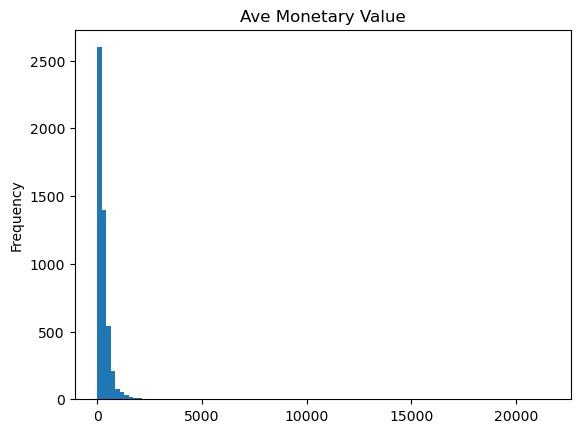

In [37]:
RFM_CalibrationVsHoldOut['Average Monetary Value Per Order'].plot(kind="hist", bins=100,title="Ave Monetary Value")

In [38]:
RFM_CalibrationVsHoldOut.describe()

,Customer ID,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order Date,Most Recent Order Date,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Order,Frequency_HoldOut_Period,Total Monetary Value_HoldOut_Period
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979,4979,4979.000000,4979.000000,4978.000000,4979.000000,4979.000000,4979.000000
mean,15340.468769,4.734686,3.734686,193.218116,366.023900,2010-06-11 12:38:08.218517760,2010-12-21 17:46:15.605543168,2498.536589,448.258616,112.958988,280.907776,1.557341,917.422860
min,12346.000000,1.000000,0.000000,0.000000,0.000000,2009-12-01 07:45:00,2009-12-01 09:55:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13883.500000,1.000000,0.000000,0.000000,242.000000,2010-01-26 14:40:00,2010-10-03 12:54:00,319.575000,173.605000,0.000000,0.000000,0.000000,0.000000
50%,15336.000000,2.000000,1.000000,152.000000,402.000000,2010-05-06 12:54:00,2011-01-17 11:34:00,782.950000,301.200000,66.000000,200.170000,1.000000,90.000000
75%,16815.500000,5.000000,4.000000,363.000000,502.000000,2010-10-13 15:12:00,2011-05-05 14:16:30,2012.950000,465.360000,164.916667,370.369444,2.000000,677.400000
max,18287.000000,173.000000,172.000000,556.000000,558.000000,2011-06-12 12:00:00,2011-06-12 13:51:00,441293.980000,39916.500000,558.000000,21535.900000,82.000000,168469.600000
std,1702.748365,7.886837,7.886837,189.236873,157.502776,NaN,NaN,11187.162748,1073.273149,137.962712,534.917477,3.263085,5510.228388


# Simple "Average" Method Of Estimating Customer Lifetime Value
Average Customer Lifetime Value 
<br>
= Annual Purchases Per Year x Ave Customer Lifespan(Years)
<br>
= (Ave Purchase Value Per Purchase x Ave Purchase Per Year) x Ave Customer Lifespan(Years)
<br>
= (Ave Purchase Value Per Purchase x (365 Days / Ave Time Between Purchase Days) ) x Ave Customer Lifespan(Years)

In [39]:
#filter out the customers with only one purchase
AvePurchaseVal=RFM_CalibrationVsHoldOut[RFM_CalibrationVsHoldOut["Frequency"]>1]["Average Monetary Value Per Order"].mean()

print("The average purchase value across all customers with > 1 purchase was $"+str(round(AvePurchaseVal,1)))

#filter out the customers with only one purchase
AvePurchaseFrequency=(round(RFM_CalibrationVsHoldOut[RFM_CalibrationVsHoldOut["Frequency"]>1]["Average Time Between Orders In Days"].mean(),1))
AnnualAvePurchaseFrequency=(round(365/RFM_CalibrationVsHoldOut[RFM_CalibrationVsHoldOut["Frequency"]>1]["Average Time Between Orders In Days"].mean(),1))

print("The ave time between orders across all customers with > 1 purchase was "+str(AvePurchaseFrequency)+" days.This translates to "+str(AnnualAvePurchaseFrequency)+" purchases per year")

The average purchase value across all customers with > 1 purchase was $416.9
The ave time between orders across all customers with > 1 purchase was 167.6 days.This translates to 2.2 purchases per year


Assume the average Online Retail customer lifespan is 2 years based on this article (This is a guesstimate only for demo purposes)
<br>
I could not find any reliable benchmarks :(

In [40]:
AveCLV=AvePurchaseVal*AnnualAvePurchaseFrequency*2
print("Average CLV= $"+str(round(AveCLV,1)))

Average CLV= $1834.3


While this definition of CLV is intuitively straightforward , there are a number of practical challenges :
<ul>
<li>Diversity of Customer Segments : If the customer profiles are quite heterogenous taking simple averages can skew results</li>
<li>Estimate of Ave Customer Lifespans : Requires sampling data over sufficiently long enough periods to observe enough active vs inactive customers.</li>
<li>Different time scales : Customers will have joined at different points and averages will not capture discount rate effects</li>
</ul>  

# PyMC Marketing
#PyMC Marketing is a python library for marketing mix modeling and customer lifetime value 
#modules allow businesses to make data-driven decisions about their marketing campaigns.

Code below is adapted from the example here https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html

# Generate Summarized RFM Data

In [41]:
from pymc_marketing import clv

pymc_mktg_rfm_data = clv.utils.rfm_summary(
    train_data,
    customer_id_col = "Customer ID",
    datetime_col = "InvoiceDate",
    monetary_value_col = "TotalPrice",
    datetime_format = "%Y/%m/%d %H:%M:%S",
    time_unit = "D")

pymc_mktg_rfm_data.sort_values("frequency",ascending=False)

,customer_id,frequency,recency,T,monetary_value
2126,14911.0,172.0,555.0,558.0,1132.579186
2472,15311.0,149.0,553.0,558.0,596.686913
1861,14606.0,139.0,553.0,556.0,184.139856
309,12748.0,133.0,553.0,555.0,245.691805
4605,17841.0,127.0,554.0,557.0,332.505512
...,...,...,...,...,...
3461,16492.0,0.0,0.0,360.0,0.000000
3460,16491.0,0.0,0.0,233.0,0.000000
3459,16490.0,0.0,0.0,256.0,0.000000
3456,16486.0,0.0,0.0,357.0,0.000000


In [42]:
# Do Not Use - this is a sense check calc against other manual RFM function 

# #filter out the customers with only one purchase
# AvePurchaseVal=pymc_mktg_rfm_data[pymc_mktg_rfm_data["frequency"]>0]["monetary_value"].mean()

# print("The average purchase value across all customers with > 1 purchase was $"+str(round(AvePurchaseVal,1)))

# #filter out the customers with only one purchase
# pymc_mktg_rfm_data["Ave Time Between Orders"]=(round(pymc_mktg_rfm_data["T"]/(pymc_mktg_rfm_data["frequency"]+1),1))

# AvePurchaseFrequency=round(pymc_mktg_rfm_data["Ave Time Between Orders"].mean(),1)
# AnnualAvePurchaseFrequency=(round(365/AvePurchaseFrequency,1))

# print("The ave time between orders across all customers with > 1 purchase was "+str(AvePurchaseFrequency)+" days.This translates to "+str(AnnualAvePurchaseFrequency)+" purchases per year")

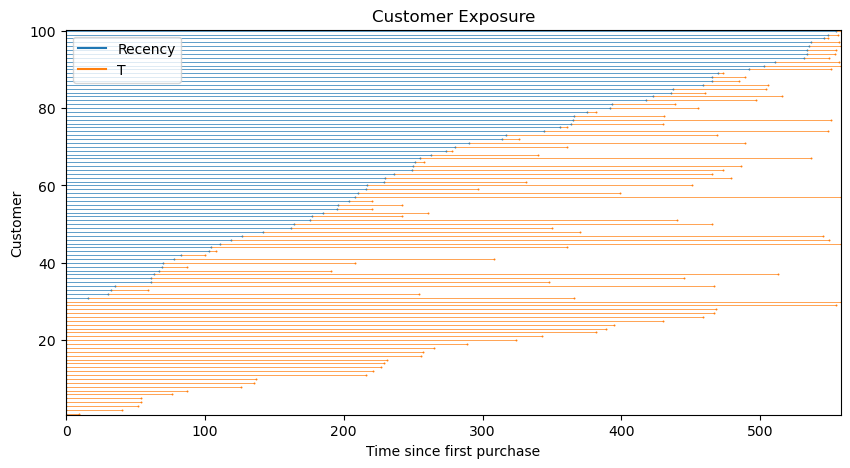

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    pymc_mktg_rfm_data
    .sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

# Fit Customer Probability Models To The Training Data

# Model Purchase Frequency & Drop Out Rate (Alive/Dead Probability)

https://www.pymc-marketing.io/en/stable/notebooks/clv/bg_nbd.html

Fit model using Maximum A Posteriori (MAP) estimates - this produces point estimates for the parameters.

In [44]:
bgm_map = clv.BetaGeoModel(data=pymc_mktg_rfm_data)
bgm_map.fit(fit_method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [45]:
bgm_map.fit_summary()

a         0.158
alpha    65.478
b         3.369
r         0.674
Name: value, dtype: float64

Fit model using MonteCarlo Markov Chain - This creates probablistic sets of results rather than point estimates

As per the documentation: 

This next bit changes the default priors for the 4 parameters which unspecific will follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10. Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys: ‘dist’ representing the name of PyMC distribution and ‘kwargs’ that holds an optional dictionary of all parameters we wish to pass to the distribution

In [46]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}

In [47]:
bgm_mcmc = clv.BetaGeoModel(
    data = pymc_mktg_rfm_data,
    model_config = model_config,
)
bgm_mcmc.build_model()
bgm_mcmc

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [48]:
sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}

bgm_mcmc.fit(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 299 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [49]:
bgm_mcmc.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.180,0.036,0.116,0.248,0.001,0.000,3978.0,4216.0,1.0
alpha,62.598,2.100,58.704,66.533,0.032,0.023,4250.0,4688.0,1.0
b,4.096,1.239,2.053,6.337,0.021,0.015,4011.0,4007.0,1.0
r,0.654,0.017,0.621,0.686,0.000,0.000,4286.0,4439.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'b'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

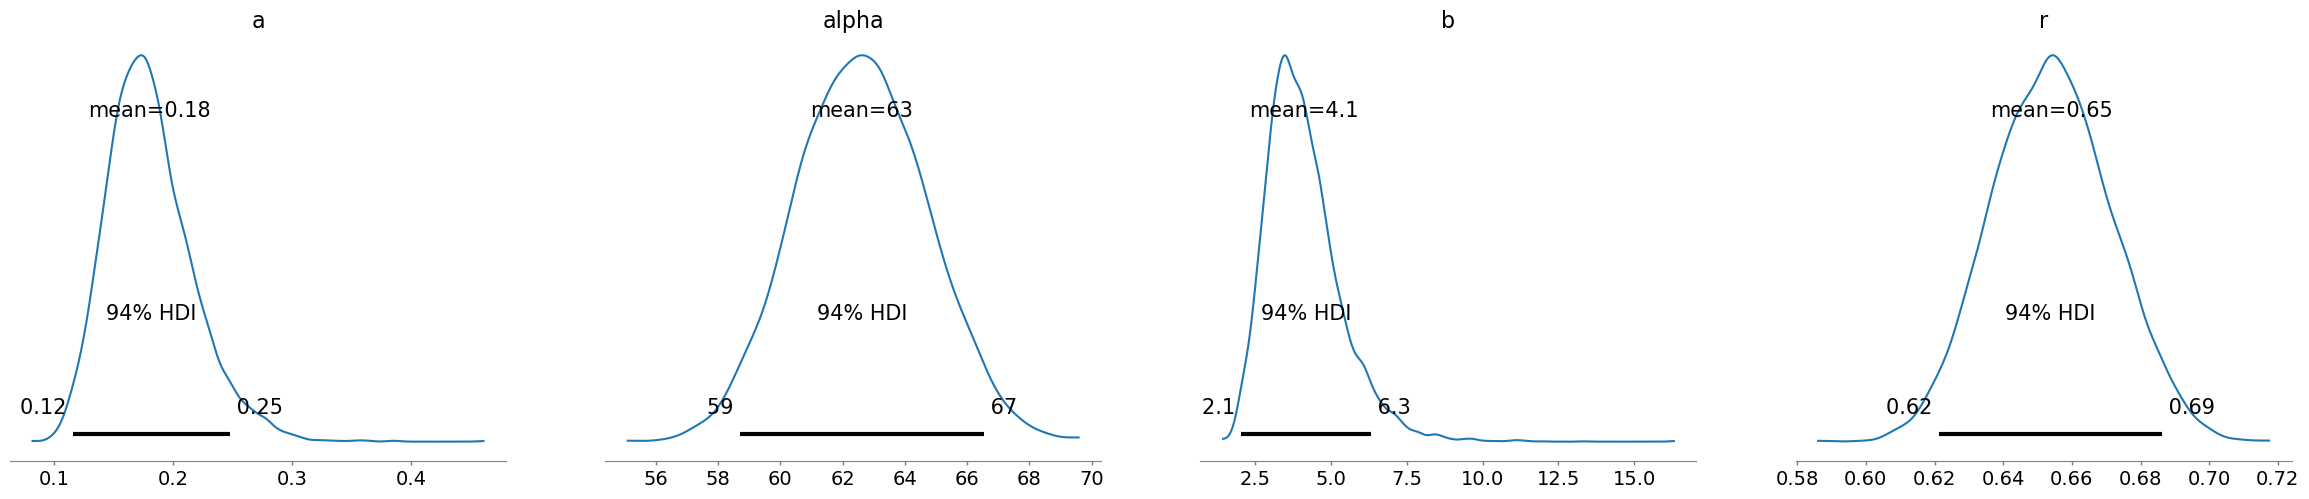

In [50]:
import arviz as az
from arviz.labels import MapLabeller

az.plot_posterior(bgm_mcmc.fit_result)

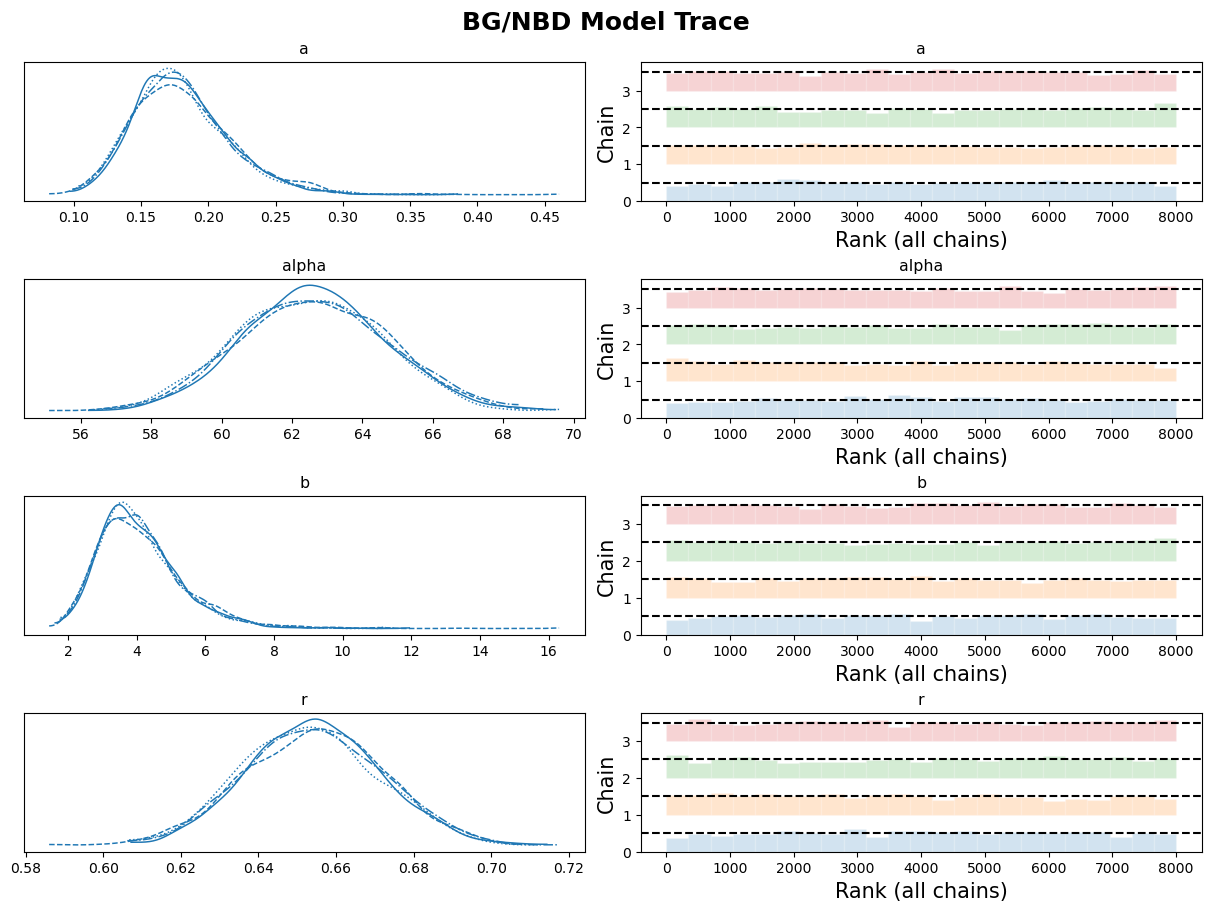

In [51]:
# plot posterior distributions of the parameters and the rank plots

axes = az.plot_trace(
    data=bgm_mcmc.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("BG/NBD Model Trace", fontsize=18, fontweight="bold");

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

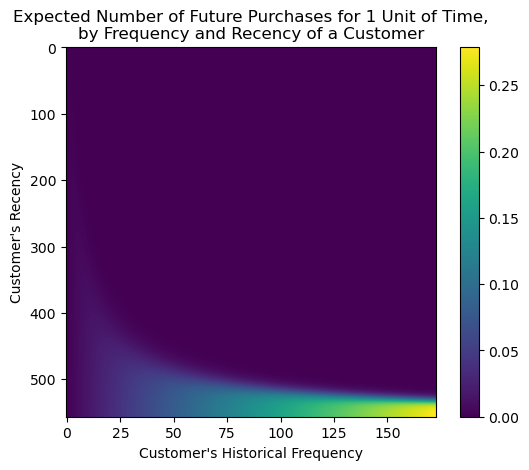

In [52]:
clv.plot_frequency_recency_matrix(bgm_mcmc)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

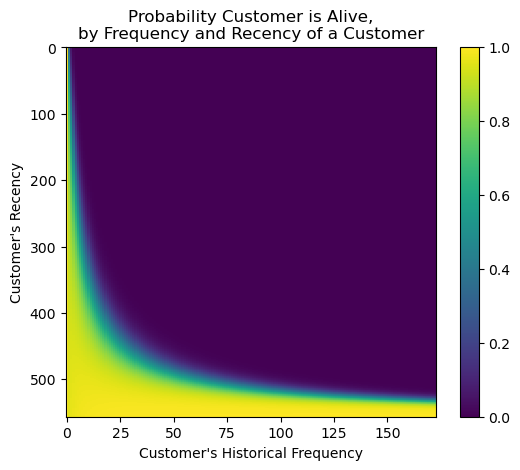

In [53]:
clv.plot_probability_alive_matrix(bgm_mcmc)

In [54]:
# randomCustomer=np.random.choice(list(AggPurchasesByCustomerByDate['Customer ID']))

randomCustomer=17062.0

randomCustomerHistory=AggPurchasesByCustomerByDate[AggPurchasesByCustomerByDate['Customer ID'] == randomCustomer]
randomCustomerHistory[["Customer ID","InvoiceDateOnly","Total Purchase Value On Same Day"]]

randomCustomer_pymc_mktg_rfm_data_total=pd.DataFrame()
for i in range(2, len(randomCustomerHistory), 1):
    
    randomCustomer_pymc_mktg_rfm_data = clv.utils.rfm_summary(
    randomCustomerHistory[:i],
    customer_id_col = "Customer ID",
    datetime_col = "InvoiceDateOnly",
    monetary_value_col = "Total Purchase Value On Same Day",
    datetime_format = "%Y/%m/%d",
    time_unit = "D")
    
    randomCustomer_pymc_mktg_rfm_data_total=pd.concat([randomCustomer_pymc_mktg_rfm_data_total, randomCustomer_pymc_mktg_rfm_data], axis=0)
    
randomCustomer_pymc_mktg_rfm_data_total=randomCustomer_pymc_mktg_rfm_data_total.reset_index(drop=True)

randomCustomer_pymc_mktg_rfm_data_total=randomCustomer_pymc_mktg_rfm_data_total[1:]
randomCustomer_pymc_mktg_rfm_data_total=randomCustomer_pymc_mktg_rfm_data_total.reset_index(drop=True)

#Am sure there is a way to programmatically insert the blank lines but it was easier to manually do this....
noPurchaseDates=[[17062.0,2.0,70.0,71.0,0],
[17062.0,2.0,70.0,72.0,0],
[17062.0,2.0,70.0,73.0,0],
[17062.0,3.0,70.0,75.0,0],
[17062.0,3.0,70.0,75.0,0],
[17062.0,3.0,70.0,75.0,0],
[17062.0,3.0,70.0,76.0,0],
[17062.0,3.0,70.0,77.0,0],
[17062.0,3.0,70.0,78.0,0],
[17062.0,3.0,70.0,79.0,0],
[17062.0,3.0,70.0,80.0,0]]

noPurchaseDF=pd.DataFrame(noPurchaseDates,columns=['customer_id','frequency','recency','T','monetary_value'])
randomCustomer_pymc_mktg_rfm_data_total=pd.concat([randomCustomer_pymc_mktg_rfm_data_total, noPurchaseDF],axis=0)
randomCustomer_pymc_mktg_rfm_data_total=randomCustomer_pymc_mktg_rfm_data_total.sort_values("T",ignore_index=True)
randomCustomer_pymc_mktg_rfm_data_total=randomCustomer_pymc_mktg_rfm_data_total.reset_index(drop=True)

randomCustomer_pymc_mktg_rfm_data_total

,customer_id,frequency,recency,T,monetary_value
0,17062.0,2.0,70.0,70.0,269.515000
1,17062.0,2.0,70.0,71.0,0.000000
2,17062.0,2.0,70.0,72.0,0.000000
3,17062.0,2.0,70.0,73.0,0.000000
4,17062.0,3.0,74.0,74.0,256.203333
5,17062.0,3.0,70.0,75.0,0.000000
6,17062.0,3.0,70.0,75.0,0.000000
7,17062.0,3.0,70.0,75.0,0.000000
8,17062.0,3.0,70.0,76.0,0.000000
9,17062.0,3.0,70.0,77.0,0.000000


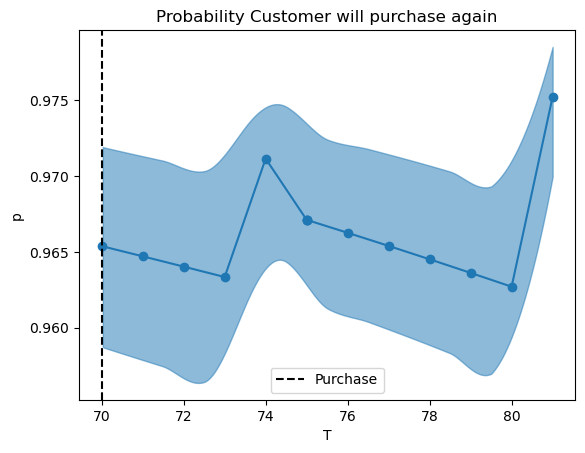

In [55]:
randomCustomer_p_alive = bgm_mcmc.expected_probability_alive(
    customer_id=randomCustomer_pymc_mktg_rfm_data_total["customer_id"],
    frequency=randomCustomer_pymc_mktg_rfm_data_total["frequency"],
    recency=randomCustomer_pymc_mktg_rfm_data_total["recency"],
    T=randomCustomer_pymc_mktg_rfm_data_total["T"],
)

az.plot_hdi(randomCustomer_pymc_mktg_rfm_data_total["T"], randomCustomer_p_alive, color="C0")
plt.plot(randomCustomer_pymc_mktg_rfm_data_total["T"], randomCustomer_p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(randomCustomer_pymc_mktg_rfm_data_total["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title("Probability Customer will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

In [56]:
randomCustomer_pymc_mktg_rfm_data_total["Prob Of Alive"]=randomCustomer_p_alive.mean(("chain", "draw")).values
randomCustomer_pymc_mktg_rfm_data_total

,customer_id,frequency,recency,T,monetary_value,Prob Of Alive
0,17062.0,2.0,70.0,70.0,269.515000,0.965389
1,17062.0,2.0,70.0,71.0,0.000000,0.964716
2,17062.0,2.0,70.0,72.0,0.000000,0.964036
3,17062.0,2.0,70.0,73.0,0.000000,0.963349
4,17062.0,3.0,74.0,74.0,256.203333,0.971161
5,17062.0,3.0,70.0,75.0,0.000000,0.967121
6,17062.0,3.0,70.0,75.0,0.000000,0.967121
7,17062.0,3.0,70.0,75.0,0.000000,0.967121
8,17062.0,3.0,70.0,76.0,0.000000,0.966269
9,17062.0,3.0,70.0,77.0,0.000000,0.965402


In [57]:
prob_of_alive = bgm_mcmc.expected_probability_alive(
    customer_id=pymc_mktg_rfm_data["customer_id"],
    frequency=pymc_mktg_rfm_data["frequency"],
    recency=pymc_mktg_rfm_data["recency"],
    T=pymc_mktg_rfm_data["T"] # add t days NoOfDaysToPredict.days
)

In [58]:
predict_future_purchases = bgm_mcmc.expected_num_purchases(
    customer_id=pymc_mktg_rfm_data["customer_id"],
    t=NoOfDaysToPredict.days,
    frequency=pymc_mktg_rfm_data["frequency"],
    recency=pymc_mktg_rfm_data["recency"],
    T=pymc_mktg_rfm_data["T"]
)

In [59]:
sdata = pymc_mktg_rfm_data.copy()
predictionColName="expected_purchases in "+str(NoOfDaysToPredict.days)+" Days"
sdata[predictionColName] = predict_future_purchases.mean(("chain", "draw")).values
sdata.sort_values(by=predictionColName,ascending=False)

predictionColName2="Prob of Alive At End Of Calibration Period"
sdata[predictionColName2] = prob_of_alive.mean(("chain", "draw")).values
sdata


,customer_id,frequency,recency,T,monetary_value,expected_purchases in 179 Days,Prob of Alive At End Of Calibration Period
0,12346.0,7.0,400.0,545.0,11066.637143,1.936394,0.874984
1,12347.0,4.0,221.0,224.0,729.435000,2.738459,0.974033
2,12348.0,3.0,190.0,258.0,495.746667,1.851554,0.933755
3,12349.0,2.0,182.0,409.0,801.310000,0.821094,0.830219
4,12350.0,0.0,0.0,130.0,0.000000,0.590682,1.000000
...,...,...,...,...,...,...,...
4974,18283.0,9.0,458.0,478.0,119.496667,3.062509,0.979149
4975,18284.0,0.0,0.0,251.0,0.000000,0.366484,1.000000
4976,18285.0,0.0,0.0,480.0,0.000000,0.213399,1.000000
4977,18286.0,1.0,247.0,543.0,833.480000,0.424266,0.878918


Text(0.5, 1.0, 'Expected purchases of a new customer in the first 365 days')

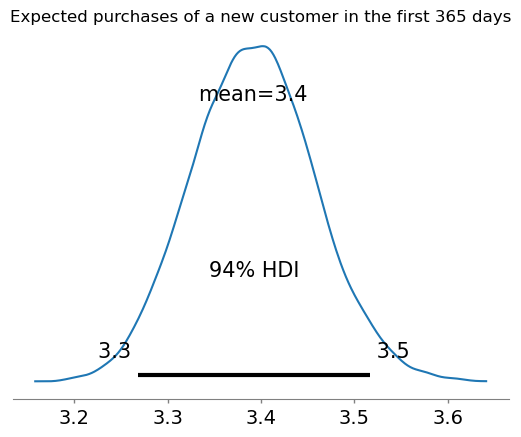

In [60]:
X=365
az.plot_posterior(bgm_mcmc.expected_num_purchases_new_customer(t=X))

plt.title("Expected purchases of a new customer in the first "+str(X)+" days")


# PyMC Marketing : Modelling Monetary Value Of Purchases
<br>https://www.pymc-marketing.io/en/stable/notebooks/clv/gamma_gamma.html

In [61]:
nonzero_data = pymc_mktg_rfm_data.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
0,12346.0,7.0,400.0,545.0,11066.637143
1,12347.0,4.0,221.0,224.0,729.435000
2,12348.0,3.0,190.0,258.0,495.746667
3,12349.0,2.0,182.0,409.0,801.310000
6,12352.0,5.0,130.0,212.0,352.372000
...,...,...,...,...,...
4972,18280.0,1.0,117.0,214.0,180.600000
4973,18281.0,1.0,397.0,397.0,80.820000
4974,18283.0,9.0,458.0,478.0,119.496667
4977,18286.0,1.0,247.0,543.0,833.480000


In [62]:
nonzero_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.133086
frequency,0.133086,1.000000


In [63]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.index,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [64]:
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [65]:
sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}

gg.fit(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 207 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [66]:
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,2.341,0.128,2.096,2.569,0.003,0.002,2186.0,3012.0,1.0
q,3.555,0.125,3.322,3.799,0.003,0.002,2431.0,3242.0,1.0
v,457.790,39.104,386.387,530.833,0.880,0.622,1969.0,2822.0,1.0


array([<Axes: title={'center': 'p'}>, <Axes: title={'center': 'q'}>,
       <Axes: title={'center': 'v'}>], dtype=object)

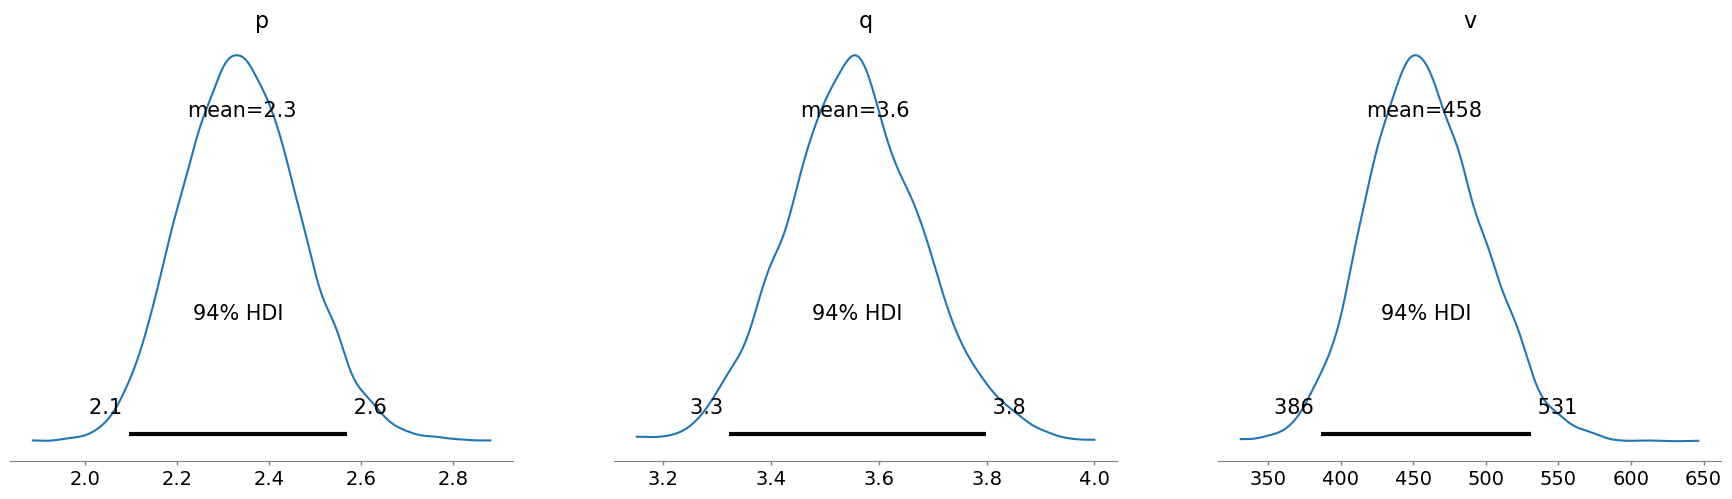

In [67]:
az.plot_posterior(gg.fit_result)

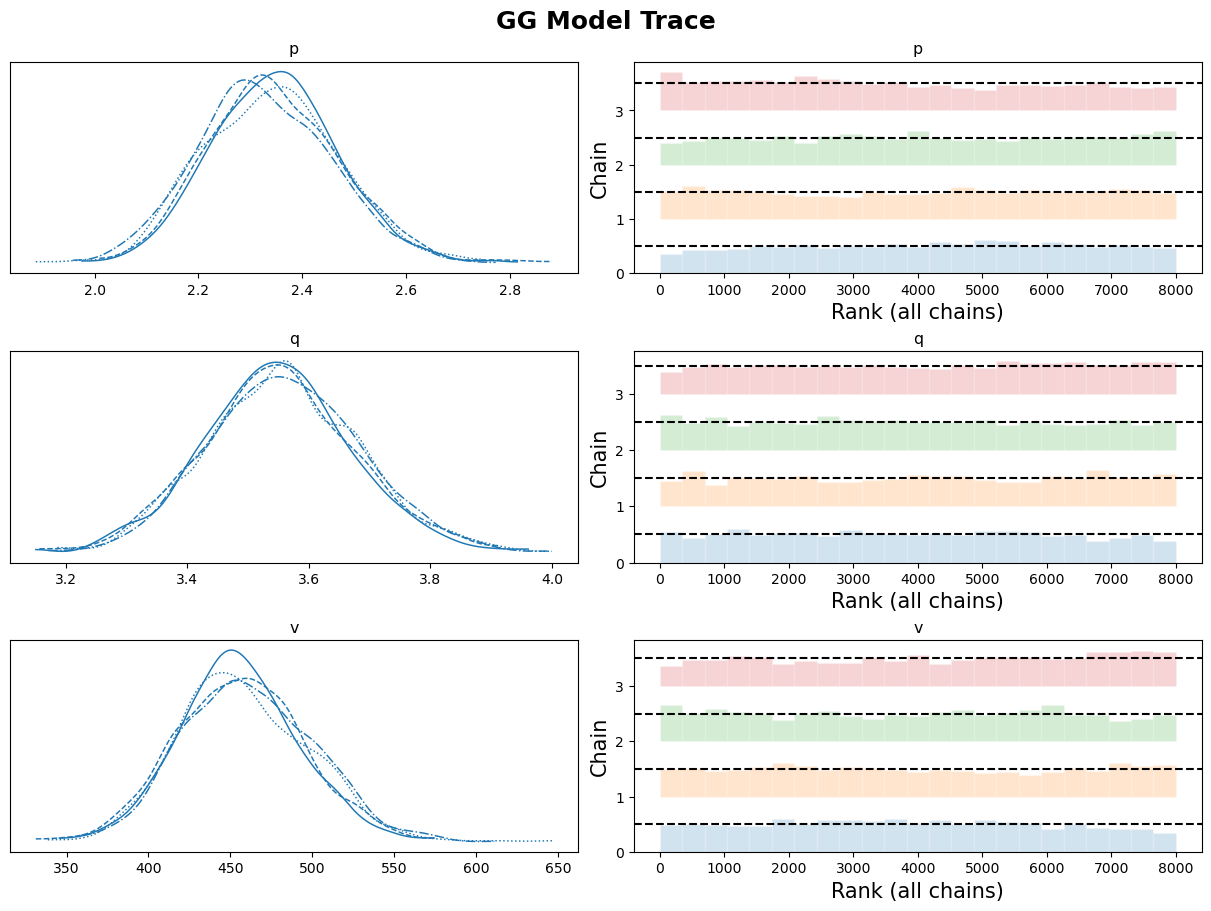

In [68]:
# plot posterior distributions of the parameters and the rank plots

axes = az.plot_trace(
    data=gg.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("GG Model Trace", fontsize=18, fontweight="bold");

In [69]:
#compute the conditional expectation of the average profit per transaction for a group of one or more customers.

expected_spend = gg.expected_customer_spend(
    customer_id=nonzero_data.index,
    mean_transaction_value=nonzero_data["monetary_value"],
    frequency=nonzero_data["frequency"],
)

In [70]:
nonzero_data["Pred Ave Monetary Value At End Calibration Period"] = expected_spend.mean(("chain", "draw")).values
nonzero_data

C:\Users\Zhi-Jing.Eu\AppData\Local\Temp\ipykernel_22900\2428142302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonzero_data["Pred Ave Monetary Value At End Calibration Period"] = expected_spend.mean(("chain", "draw")).values


,customer_id,frequency,recency,T,monetary_value,Pred Ave Monetary Value At End Calibration Period
0,12346.0,7.0,400.0,545.0,11066.637143,9626.464855
1,12347.0,4.0,221.0,224.0,729.435000,662.496100
2,12348.0,3.0,190.0,258.0,495.746667,474.915066
3,12349.0,2.0,182.0,409.0,801.310000,665.788361
6,12352.0,5.0,130.0,212.0,352.372000,364.113293
...,...,...,...,...,...,...
4972,18280.0,1.0,117.0,214.0,180.600000,304.391131
4973,18281.0,1.0,397.0,397.0,80.820000,256.682967
4974,18283.0,9.0,458.0,478.0,119.496667,151.847040
4977,18286.0,1.0,247.0,543.0,833.480000,616.554955


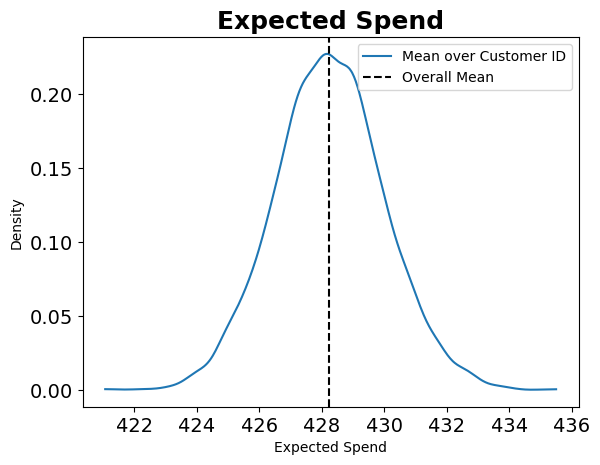

In [71]:
fig, ax = plt.subplots()
az.plot_dist(expected_spend.mean("customer_id"), label="Mean over Customer ID", ax=ax)
ax.axvline(x=expected_spend.mean(), color="black", ls="--", label="Overall Mean")
ax.legend(loc="upper right")
ax.set(xlabel="Expected Spend", ylabel="Density")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

# Compare BG-NBD+GG Model Predictions Against Test (Holdout) Period


In [72]:
sdata = pymc_mktg_rfm_data.copy()

FULL_pymc_mktg_rfm_data = clv.utils.rfm_summary(
    data,
    customer_id_col = "Customer ID",
    datetime_col = "InvoiceDate",
    monetary_value_col = "TotalPrice",
    datetime_format = "%Y/%m/%d %H:%M:%S",
    time_unit = "D")

FULL_pymc_mktg_rfm_data.rename(columns = {'frequency':'frequency_test+train period'}, inplace = True)
FULL_pymc_mktg_rfm_data=FULL_pymc_mktg_rfm_data[["frequency_test+train period"]]
sdata=sdata.join(FULL_pymc_mktg_rfm_data)

In [73]:
#below computes the predictions for ALL customers in the training part of dataset (NOT just the non-zero frequency customers)

predict_future_purchases = bgm_mcmc.expected_num_purchases(
    customer_id=pymc_mktg_rfm_data["customer_id"],
    t=NoOfDaysToPredict.days,
    frequency=pymc_mktg_rfm_data["frequency"],
    recency=pymc_mktg_rfm_data["recency"],
    T=pymc_mktg_rfm_data["T"]
)

expected_spend = gg.expected_customer_spend(
    customer_id=pymc_mktg_rfm_data["customer_id"],
    mean_transaction_value=pymc_mktg_rfm_data["monetary_value"], 
    frequency=pymc_mktg_rfm_data["frequency"],
)

In [74]:
#this bit stitches all of the predictions together in a single dataframe

sdata["Prob of Alive At End Of Calibration Period"] = prob_of_alive.mean(("chain", "draw")).values

sdata["expected_no_of_purchases in calibration period"] = predict_future_purchases.mean(("chain", "draw")).values.round(2)

sdata["actual_no_of_purchases in calibration period"]=sdata["frequency_test+train period"]-sdata["frequency"]

sdata["expected_monetary_value"] = expected_spend.mean(("chain", "draw")).values.round(2)

sdata.sort_values(by="customer_id",ascending=False)

,customer_id,frequency,recency,T,monetary_value,frequency_test+train period,Prob of Alive At End Of Calibration Period,expected_no_of_purchases in calibration period,actual_no_of_purchases in calibration period,expected_monetary_value
4978,18287.0,3.0,370.0,391.0,679.793333,27.0,0.965894,1.36,24.0,609.79
4977,18286.0,1.0,247.0,543.0,833.480000,3.0,0.878918,0.42,2.0,616.55
4976,18285.0,0.0,0.0,480.0,0.000000,3.0,1.000000,0.21,3.0,417.88
4975,18284.0,0.0,0.0,251.0,0.000000,0.0,1.000000,0.37,0.0,417.88
4974,18283.0,9.0,458.0,478.0,119.496667,12.0,0.979149,3.06,3.0,151.85
...,...,...,...,...,...,...,...,...,...,...
4,12350.0,0.0,0.0,130.0,0.000000,0.0,1.000000,0.59,0.0,417.88
3,12349.0,2.0,182.0,409.0,801.310000,3.0,0.830219,0.82,1.0,665.79
2,12348.0,3.0,190.0,258.0,495.746667,4.0,0.933755,1.85,1.0,474.92
1,12347.0,4.0,221.0,224.0,729.435000,7.0,0.974033,2.74,3.0,662.50


In [75]:
sdata.describe()

,customer_id,frequency,recency,T,monetary_value,frequency_test+train period,Prob of Alive At End Of Calibration Period,expected_no_of_purchases in calibration period,actual_no_of_purchases in calibration period,expected_monetary_value
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000
mean,15340.468769,3.734686,193.218116,366.023900,280.907776,4.594698,0.911299,1.501006,0.860012,424.858411
std,1702.748365,7.886837,189.236873,157.502776,534.917477,9.905967,0.146601,2.284151,12.584655,355.377702
min,12346.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,-163.000000,44.220000
25%,13883.500000,0.000000,0.000000,242.000000,0.000000,0.000000,0.892413,0.420000,-2.000000,306.230000
50%,15336.000000,1.000000,152.000000,402.000000,200.170000,2.000000,0.964951,0.860000,0.000000,417.880000
75%,16815.500000,4.000000,363.000000,502.000000,370.369444,5.000000,1.000000,1.700000,3.000000,417.880000
max,18287.000000,172.000000,556.000000,558.000000,21535.900000,254.000000,1.000000,48.530000,254.000000,10515.080000


In [76]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

freq_actual=sdata['actual_no_of_purchases in calibration period'].to_list()
freq_predicted=sdata['expected_no_of_purchases in calibration period'].to_list()
monetary_actual=sdata['monetary_value'].to_list()
monetary_predicted=sdata['expected_monetary_value'].to_list()

RMSE_For_Frequency = root_mean_squared_error(freq_actual, freq_predicted)**0.5

RMSE_For_Monetary = root_mean_squared_error(monetary_actual, monetary_predicted)**0.5

print("RMSE For Frequency In HoldOut Period = "+str(RMSE_For_Frequency.round(2))+" Purchases")
print("RMSE For Monetary Value In HoldOut Period = $"+str(RMSE_For_Monetary.round(2)))

MAE_For_Frequency = mean_absolute_error(freq_actual, freq_predicted)

MAE_For_Monetary = mean_absolute_error(monetary_actual, monetary_predicted)

print("MAE For Frequency In HoldOut Period = "+str(MAE_For_Frequency.round(2))+" Purchases")
print("MAE For Monetary Value In HoldOut Period = $"+str(MAE_For_Monetary.round(2)))


RMSE For Frequency In HoldOut Period = 14.03 Purchases
RMSE For Monetary Value In HoldOut Period = $302.31
MAE For Frequency In HoldOut Period = 6.45 Purchases
MAE For Monetary Value In HoldOut Period = $184.01


RMSE results are quite poor but worth noting that RMSE by nature tends to be more sensitive towards outliers and larger errors.
MAE provides a slightly better results but similarly reflects that f and MV variables will have given the long tail distributions of both of these

# Estimate Customer Lifetime Value BEYOND The Holdout Period

#Take full dataset (Calibration PLUS HOLDOUT) and rerun to get RFM characteristics

In [77]:
full_pymc_mktg_rfm_data = clv.utils.rfm_summary(
    data,
    customer_id_col = "Customer ID",
    datetime_col = "InvoiceDate",
    monetary_value_col = "TotalPrice",
    datetime_format = "%Y/%m/%d %H:%M:%S",
    time_unit = "D")

full_pymc_mktg_rfm_data.sort_values("frequency",ascending=False)

,customer_id,frequency,recency,T,monetary_value
2541,14911.0,254.0,737.0,738.0,1162.358268
400,12748.0,202.0,735.0,735.0,279.101436
2938,15311.0,195.0,738.0,738.0,594.605846
5436,17841.0,192.0,736.0,737.0,366.423490
2239,14606.0,180.0,735.0,736.0,170.255889
...,...,...,...,...,...
2869,15242.0,0.0,0.0,422.0,0.000000
513,12861.0,0.0,0.0,619.0,0.000000
1087,13445.0,0.0,0.0,626.0,0.000000
4497,16886.0,0.0,0.0,456.0,0.000000


In [78]:
prob_of_alive = bgm_mcmc.expected_probability_alive(
    customer_id=full_pymc_mktg_rfm_data["customer_id"],
    frequency=full_pymc_mktg_rfm_data["frequency"],
    recency=full_pymc_mktg_rfm_data["recency"],
    T=full_pymc_mktg_rfm_data["T"] # add t days NoOfDaysToPredict.days
)

predictionColName2="Predicted Probability Of Customer Alive At Start Of Forecast Period"
full_pymc_mktg_rfm_data[predictionColName2] = prob_of_alive.mean(("chain", "draw")).values.round(3)
full_pymc_mktg_rfm_data


,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period
0,12346.0,7.0,400.0,725.0,11066.637143,0.491
1,12347.0,7.0,402.0,404.0,717.398571,0.982
2,12348.0,4.0,363.0,438.0,449.310000,0.949
3,12349.0,3.0,571.0,589.0,1120.056667,0.968
4,12350.0,0.0,0.0,310.0,0.000000,1.000
...,...,...,...,...,...,...
5876,18283.0,18.0,655.0,658.0,146.405556,0.991
5877,18284.0,0.0,0.0,431.0,0.000000,1.000
5878,18285.0,0.0,0.0,660.0,0.000000,1.000
5879,18286.0,1.0,247.0,723.0,833.480000,0.825


In [79]:
forecastperiod=365 #days


predict_future_purchases = bgm_mcmc.expected_num_purchases(
    customer_id=full_pymc_mktg_rfm_data["customer_id"],
    t=365,
    frequency=full_pymc_mktg_rfm_data["frequency"],
    recency=full_pymc_mktg_rfm_data["recency"],
    T=full_pymc_mktg_rfm_data["T"]
)

predictionColName="expected_purchases in 365 Days"
full_pymc_mktg_rfm_data[predictionColName] = predict_future_purchases.mean(("chain", "draw")).values.round(2)
full_pymc_mktg_rfm_data


,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,expected_purchases in 365 Days
0,12346.0,7.0,400.0,725.0,11066.637143,0.491,1.69
1,12347.0,7.0,402.0,404.0,717.398571,0.982,5.62
2,12348.0,4.0,363.0,438.0,449.310000,0.949,3.10
3,12349.0,3.0,571.0,589.0,1120.056667,0.968,1.93
4,12350.0,0.0,0.0,310.0,0.000000,1.000,0.62
...,...,...,...,...,...,...,...
5876,18283.0,18.0,655.0,658.0,146.405556,0.991,9.04
5877,18284.0,0.0,0.0,431.0,0.000000,1.000,0.47
5878,18285.0,0.0,0.0,660.0,0.000000,1.000,0.32
5879,18286.0,1.0,247.0,723.0,833.480000,0.825,0.62


In [80]:
expected_spend = gg.expected_customer_spend(
    customer_id=full_pymc_mktg_rfm_data.index,
    mean_transaction_value=full_pymc_mktg_rfm_data["monetary_value"],
    frequency=full_pymc_mktg_rfm_data["frequency"],
)

predictionColName3="Pred Ave Monetary Value Per Transaction"
full_pymc_mktg_rfm_data[predictionColName3] = expected_spend.mean(("chain", "draw")).values.round(2)
full_pymc_mktg_rfm_data

,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,expected_purchases in 365 Days,Pred Ave Monetary Value Per Transaction
0,12346.0,7.0,400.0,725.0,11066.637143,0.491,1.69,9626.46
1,12347.0,7.0,402.0,404.0,717.398571,0.982,5.62,676.87
2,12348.0,4.0,363.0,438.0,449.310000,0.949,3.10,442.53
3,12349.0,3.0,571.0,589.0,1120.056667,0.968,1.93,932.44
4,12350.0,0.0,0.0,310.0,0.000000,1.000,0.62,417.88
...,...,...,...,...,...,...,...,...
5876,18283.0,18.0,655.0,658.0,146.405556,0.991,9.04,161.97
5877,18284.0,0.0,0.0,431.0,0.000000,1.000,0.47,417.88
5878,18285.0,0.0,0.0,660.0,0.000000,1.000,0.32,417.88
5879,18286.0,1.0,247.0,723.0,833.480000,0.825,0.62,616.55


In [81]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm_mcmc,
    customer_id=full_pymc_mktg_rfm_data.index,
    mean_transaction_value=full_pymc_mktg_rfm_data["monetary_value"],
    frequency=full_pymc_mktg_rfm_data["frequency"],
    recency=full_pymc_mktg_rfm_data["recency"],
    T=full_pymc_mktg_rfm_data["T"],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq="D"
)

In [82]:
full_pymc_mktg_rfm_data["Discounted CLV"] = clv_estimate.mean(("chain", "draw")).values.round(2)
full_pymc_mktg_rfm_data

,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,expected_purchases in 365 Days,Pred Ave Monetary Value Per Transaction,Discounted CLV
0,12346.0,7.0,400.0,725.0,11066.637143,0.491,1.69,9626.46,15092.45
1,12347.0,7.0,402.0,404.0,717.398571,0.982,5.62,676.87,3524.70
2,12348.0,4.0,363.0,438.0,449.310000,0.949,3.10,442.53,1270.07
3,12349.0,3.0,571.0,589.0,1120.056667,0.968,1.93,932.44,1662.66
4,12350.0,0.0,0.0,310.0,0.000000,1.000,0.62,417.88,240.58
...,...,...,...,...,...,...,...,...,...
5876,18283.0,18.0,655.0,658.0,146.405556,0.991,9.04,161.97,1356.20
5877,18284.0,0.0,0.0,431.0,0.000000,1.000,0.47,417.88,182.78
5878,18285.0,0.0,0.0,660.0,0.000000,1.000,0.32,417.88,125.69
5879,18286.0,1.0,247.0,723.0,833.480000,0.825,0.62,616.55,355.01


In [83]:
full_pymc_mktg_rfm_data.sort_values("Discounted CLV", ascending=False).head(15)

,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,expected_purchases in 365 Days,Pred Ave Monetary Value Per Transaction,Discounted CLV
5695,18102.0,66.0,738.0,738.0,9189.930455,0.997,29.28,9046.67,245310.72
2279,14646.0,90.0,736.0,737.0,5809.905333,0.998,39.88,5745.04,212159.41
4064,16446.0,1.0,205.0,205.0,168469.600000,0.957,2.05,80769.01,153620.52
5053,17450.0,30.0,430.0,438.0,6924.523000,0.991,21.08,6695.27,130748.29
1791,14156.0,120.0,729.0,738.0,2607.329750,0.994,52.81,2587.52,126545.77
2541,14911.0,254.0,737.0,738.0,1162.358268,0.999,111.95,1159.16,120175.78
1732,14096.0,16.0,97.0,101.0,4071.434375,0.986,32.76,3837.33,116630.66
1332,13694.0,82.0,732.0,735.0,2365.279512,0.997,36.42,2339.60,78916.32
68,12415.0,22.0,503.0,527.0,6460.528636,0.982,13.20,6173.90,75495.06
5112,17511.0,50.0,735.0,737.0,3449.898200,0.996,22.26,3384.88,69775.89


In [84]:
full_pymc_mktg_rfm_data.describe()

,customer_id,frequency,recency,T,monetary_value,Predicted Probability Of Customer Alive At Start Of Forecast Period,expected_purchases in 365 Days,Pred Ave Monetary Value Per Transaction,Discounted CLV
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,4.630335,273.254208,474.247067,318.883972,0.906129,3.079320,433.083855,1453.170767
std,1715.429759,10.001176,258.971689,223.142456,2256.282323,0.174068,4.725801,1107.640535,6469.037103
min,12346.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.040000,0.000000
25%,13833.000000,0.000000,0.000000,313.000000,0.000000,0.923000,0.700000,293.610000,230.290000
50%,15313.000000,2.000000,220.000000,530.000000,213.470200,0.969000,1.760000,416.120000,562.610000
75%,16797.000000,5.000000,512.000000,668.000000,376.086667,1.000000,3.770000,417.880000,1258.230000
max,18287.000000,254.000000,738.000000,738.000000,168469.600000,1.000000,111.950000,80769.010000,245310.720000


In [95]:
full_pymc_mktg_rfm_data["Discounted CLV"].mean().round(2)

1453.17

<Axes: ylabel='Frequency'>

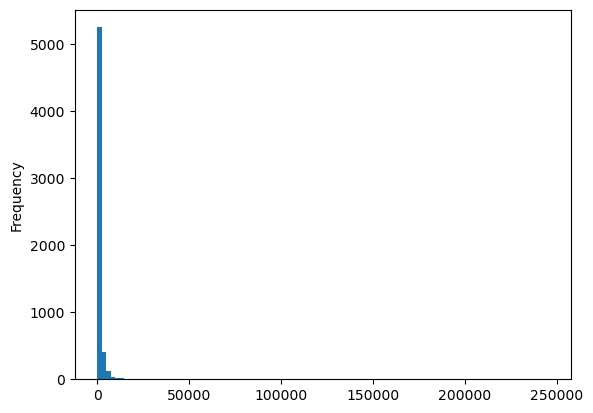

In [91]:
full_pymc_mktg_rfm_data["Discounted CLV"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

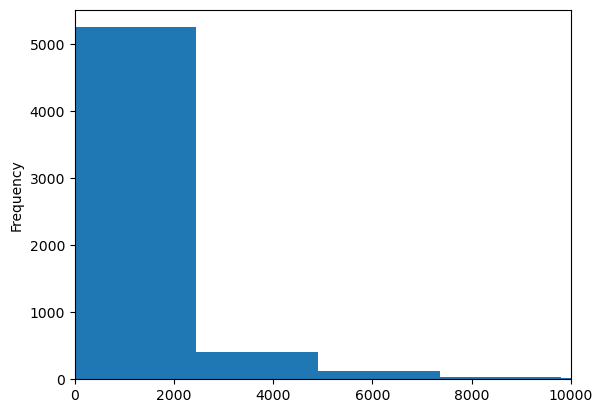

In [93]:
full_pymc_mktg_rfm_data["Discounted CLV"].plot.hist(bins=100,xlim=(0,10000))

In [104]:
TopTenCLV=full_pymc_mktg_rfm_data.sort_values("Discounted CLV", ascending=False).head(10).index.values
TopTenCLV

array([5695, 2279, 4064, 5053, 1791, 2541, 1732, 1332,   68, 5112],
      dtype=int64)

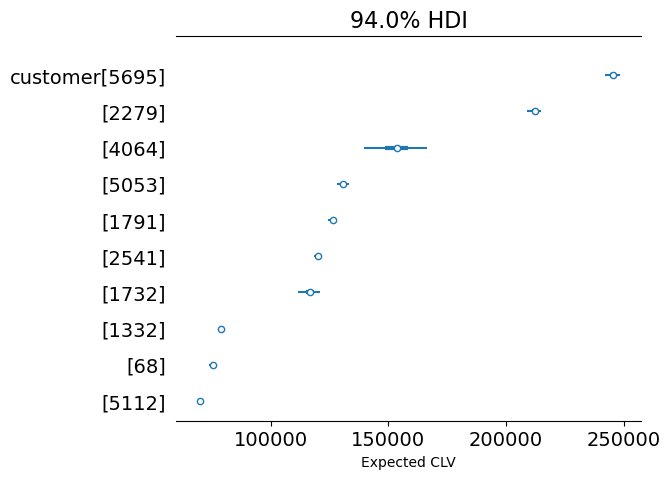

In [105]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(clv_estimate.isel(customer_id=TopTenCLV), combined=True, labeller=labeller)
plt.xlabel("Expected CLV");

In [106]:
az.summary(clv_estimate.isel(customer_id=TopTenCLV), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[5695],245310.718,1741.421,241952.052,248391.898
x[2279],212159.411,1520.739,209151.597,214779.420
x[4064],153620.522,7183.057,139739.730,166535.639
x[5053],130748.289,1382.408,128052.868,133176.067
x[1791],126545.773,998.904,124563.514,128253.089
x[2541],120175.777,873.013,118439.253,121662.219
x[1732],116630.662,2594.193,111446.280,121090.481
x[1332],78916.316,571.958,77773.546,79894.605
x[68],75495.065,788.546,73999.182,76913.357
x[5112],69775.890,498.269,68792.934,70641.281
